## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

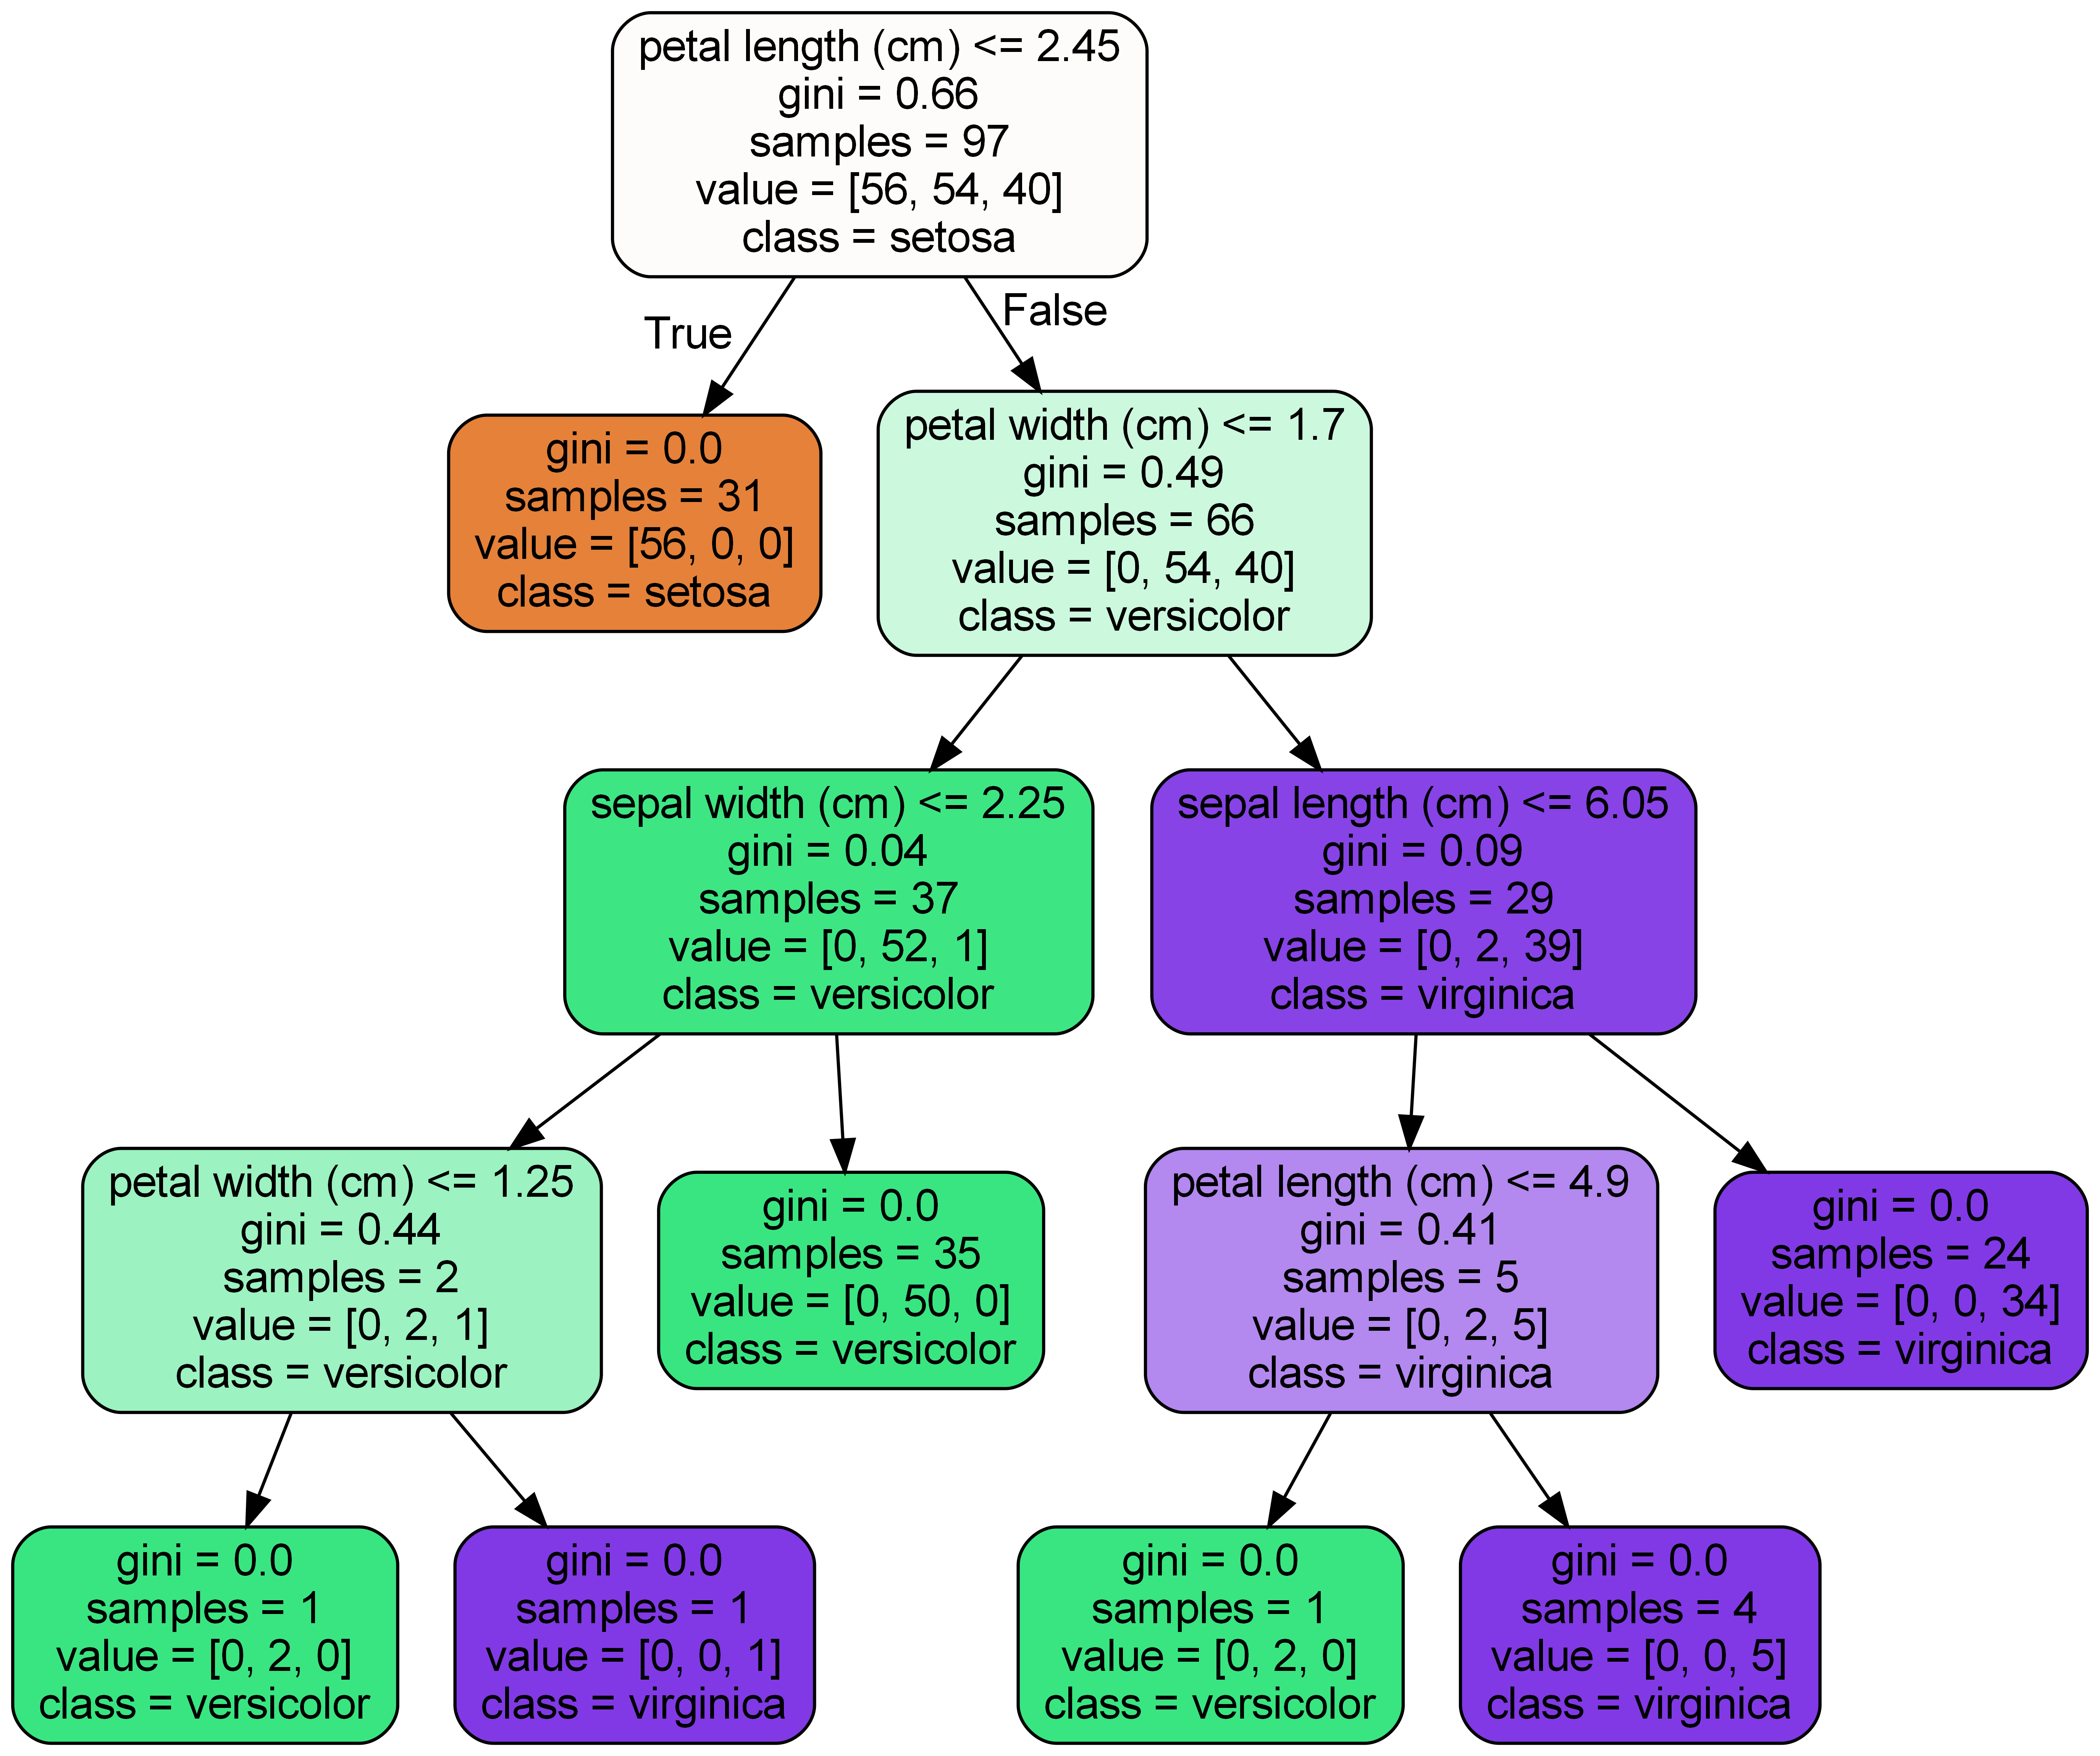

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)

# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator,
                out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True,
                proportion = False, 
                precision = 2,
                filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.sample(5)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
917,3014000001,NaN,female,NaN,80s,Korea,Gangwon-do,Taebaek-si,True,contact with patient,NaN,NaN,NaN,NaN,2020-03-04,NaN,2020-03-04,deceased
1890,6015000015,890.0,female,NaN,30s,Korea,Gyeongsangbuk-do,Yeongcheon-si,NaN,contact with patient,NaN,6.016000e+09,NaN,NaN,2020-02-25,2020-03-13,NaN,released
134,1000000135,7513.0,male,1989.0,30s,Korea,Seoul,Eunpyeong-gu,NaN,etc,NaN,NaN,NaN,NaN,2020-03-09,NaN,NaN,isolated
255,1000000256,8250.0,female,1996.0,20s,Korea,Seoul,Eunpyeong-gu,NaN,Guro-gu Call Center,NaN,NaN,NaN,NaN,2020-03-16,NaN,NaN,isolated
988,4100000043,NaN,female,1981.0,30s,Korea,Chungcheongnam-do,Asan-si,NaN,contact with patient,NaN,4.100000e+09,10.0,2020-02-27,2020-02-28,NaN,NaN,isolated


In [4]:
df.shape

(2218, 18)

In [5]:
#counts of response variable values
df['state'].value_counts(dropna = False)

isolated    1791
released     307
NaN           88
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [6]:
# Calculate subtract the data collection year (2020)
df['n_age'] = 2020 - df.birth_year

### Handle Missing Values

In [7]:
#Counts of null values 
def count_missing(df):
    na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
    na_df.columns = ['VarName', 'NullCount']
    na_df['NullPct'] = 100 * na_df['NullCount']/len(df)
    print('Shape:', df.shape)
    return na_df[(na_df['NullCount'] > 0)].round(2)

 **<font color='teal'> Print the number of missing values by column.</font>**

In [8]:
count_missing(df)

Shape: (2218, 19)


,VarName,NullCount,NullPct
0,disease,2199,99.14
1,deceased_date,2186,98.56
2,infection_order,2176,98.11
3,symptom_onset_date,2025,91.30
4,released_date,1995,89.95
5,contact_number,1807,81.47
6,infected_by,1749,78.85
7,infection_case,1055,47.57
8,global_num,904,40.76
9,n_age,454,20.47


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [10]:
# Fill NaN with value 0
df['disease'].fillna(0, inplace = True)
# Replace True with 1
df['disease'].replace(to_replace=True, value=1, inplace = True)

In [11]:
# Check the results
df['disease'].value_counts(dropna=False)

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [12]:
# Set the column names to fillna by mean
fill_mean_cols = ['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']
# Fill nan by mean values
[df[x].fillna(value = df[x].mean(), inplace = True) for x in fill_mean_cols]

[None, None, None, None, None]

In [13]:
count_missing(df)

Shape: (2218, 19)


,VarName,NullCount,NullPct
0,deceased_date,2186,98.56
1,symptom_onset_date,2025,91.30
2,released_date,1995,89.95
3,infection_case,1055,47.57
4,n_age,454,20.47
5,age,261,11.77
6,sex,145,6.54
7,confirmed_date,141,6.36
8,state,88,3.97
9,city,65,2.93


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [14]:
# Define columns that will be dropped and fill with '_'
fill_dummy_cols = ['symptom_onset_date','confirmed_date','released_date','deceased_date']

# Fill nan by '_' values
[df[x].fillna(value = '_', inplace = True) for x in fill_dummy_cols]

[None, None, None, None]

In [15]:
count_missing(df)

Shape: (2218, 19)


,VarName,NullCount,NullPct
0,infection_case,1055,47.57
1,n_age,454,20.47
2,age,261,11.77
3,sex,145,6.54
4,state,88,3.97
5,city,65,2.93


In [16]:
df.age.value_counts(dropna = False)

20s     467
50s     385
40s     303
NaN     261
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64

In [17]:
# convert n_age values to categorical data
df['age_temp'] = df["n_age"].apply(lambda x: str(x)[:1]+'0s')

#replace wrong values with nan
df['age_temp'].replace(to_replace = 'n0s', value = np.nan, inplace = True)

# Use `n_temp` to calcualte `age`
df['age'].fillna(df['age_temp'], inplace = True)

In [18]:
# Drop 'age_temp' and 'n_age'
df.drop(columns = ['age_temp', 'n_age'], axis = 0, inplace = True)

In [19]:
df.age.value_counts(dropna = False)

20s     484
50s     409
40s     319
30s     271
60s     249
NaN     151
70s     124
80s      85
10s      79
0s       29
90s      17
100s      1
Name: age, dtype: int64

In [20]:
count_missing(df)

Shape: (2218, 18)


,VarName,NullCount,NullPct
0,infection_case,1055,47.57
1,age,151,6.81
2,sex,145,6.54
3,state,88,3.97
4,city,65,2.93


In [21]:
print('Most common:')
print('city:', df['city'].mode()[0])
print('infection_case:', df['infection_case'].mode()[0])

Most common:
city: Gyeongsan-si
infection_case: contact with patient


In [22]:
df['city'].fillna(value = df['city'].mode()[0], inplace = True)
df['infection_case'].fillna(value = df['infection_case'].mode()[0], inplace = True)

In [23]:
# Check for any remaining null values
count_missing(df)
print(df.shape)

Shape: (2218, 18)
(2218, 18)


In [24]:
# Age & sex might be important vaeiables. We drop rows that do not include them
df.dropna(subset = ['age', 'sex'], inplace = True)

In [25]:
count_missing(df)
print(df.shape)

Shape: (2065, 18)
(2065, 18)


In [26]:
# Store data frame withour `state` value and drop them from original df
unknown_state_df = df.loc[df['state'].isnull()]
df.dropna(subset = ['state'], inplace = True)

print(unknown_state_df.shape)

(88, 18)


 **<font color='teal'> Check for any remaining null values.</font>**

In [27]:
count_missing(df)

Shape: (1977, 18)


,VarName,NullCount,NullPct


Remove date columns from the data.


In [28]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [29]:
print(df.nunique())

patient_id         1977
global_num         1221
sex                   2
birth_year           97
age                  11
country               4
province             17
city                126
disease               2
infection_case       16
infection_order       7
infected_by         196
contact_number       73
state                 3
dtype: int64


Review the percent of unique values by column.

In [30]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.617602
sex                0.001012
birth_year         0.049064
age                0.005564
country            0.002023
province           0.008599
city               0.063733
disease            0.001012
infection_case     0.008093
infection_order    0.003541
infected_by        0.099140
contact_number     0.036925
state              0.001517
dtype: float64


Review the range of values per column.

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,1977.0,3.952246e+09,2.214416e+09,1.000000e+09,1.400000e+09,6.001000e+09,6.001000e+09,7.000000e+09
global_num,1977.0,4.522028e+03,2.213105e+03,1.000000e+00,3.703000e+03,4.664817e+03,5.704000e+03,8.717000e+03
birth_year,1977.0,1.974933e+03,1.794281e+01,1.916000e+03,1.964000e+03,1.974989e+03,1.990000e+03,2.020000e+03
disease,1977.0,9.610521e-03,9.758574e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,1977.0,2.285714e+00,1.807702e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,1977.0,2.622161e+09,7.545482e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,1977.0,2.417601e+01,4.148117e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03


### Check for duplicated rows

In [32]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state


Print the categorical columns and their associated levels.

In [33]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,126
5,infection_case,16
6,state,3


In [34]:
df.contact_number.unique()

array([7.50000000e+01, 3.10000000e+01, 1.70000000e+01, 9.00000000e+00,
       2.00000000e+00, 4.30000000e+01, 0.00000000e+00, 6.80000000e+01,
       6.00000000e+00, 2.30000000e+01, 1.17000000e+02, 2.70000000e+01,
       8.00000000e+00, 2.41289538e+01, 1.09100000e+03, 1.31000000e+02,
       1.60000000e+01, 1.40000000e+01, 4.85000000e+02, 4.00000000e+00,
       1.90000000e+01, 2.96000000e+02, 1.50000000e+01, 3.40000000e+01,
       1.00000000e+00, 3.70000000e+01, 2.20000000e+01, 7.00000000e+00,
       1.00000000e+01, 2.80000000e+01, 2.10000000e+01, 3.00000000e+00,
       5.00000000e+00, 2.50000000e+01, 1.80000000e+01, 1.59000000e+02,
       1.10000000e+01, 3.00000000e+01, 4.10000000e+01, 7.10000000e+01,
       3.80000000e+01, 1.30000000e+01, 1.16000000e+03, 4.50000000e+02,
       6.50000000e+01, 1.56000000e+02, 3.90000000e+01, 4.70000000e+01,
       8.60000000e+01, 7.40000000e+01, 1.20000000e+01, 4.60000000e+01,
       6.40000000e+01, 6.60000000e+01, 4.00000000e+01, 4.90000000e+01,
      

In [35]:
df.sample(5)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state
708,2000000120,6305.000000,female,1965.0,50s,Korea,Gyeonggi-do,Seongnam-si,0,etc,2.285714,2.600789e+09,11.000000,isolated
1060,4100000115,4664.816591,female,1939.0,80s,Korea,Chungcheongnam-do,Cheonan-si,0,contact with patient,2.285714,4.100000e+09,14.000000,isolated
1510,6001000436,6646.000000,male,1997.0,20s,Korea,Gyeongsangbuk-do,Gyeongsan-si,0,contact with patient,2.285714,2.600789e+09,24.128954,isolated
219,1000000220,7810.000000,male,1969.0,50s,Korea,Seoul,Dongdaemun-gu,0,Dongan Church,2.285714,2.600789e+09,24.128954,isolated
1007,4100000062,4664.816591,female,1985.0,30s,Korea,Chungcheongnam-do,Asan-si,0,etc,2.285714,2.600789e+09,27.000000,isolated


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [36]:
def plot_corr_matrix (df, round_vals, mask = False):
    '''This function plots Correlation matrix'''
    
    # Compute the correlation matrix
    corr = df.corr()
    
    #Plot Corr matrix
    
    # Generate a mask for the upper triangle
    if mask:
        mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(5, 5))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr.round(round_vals), mask=mask, cmap='coolwarm', vmin = -1, vmax=1, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='Pearson Correlation Matrix')

    plt.show()

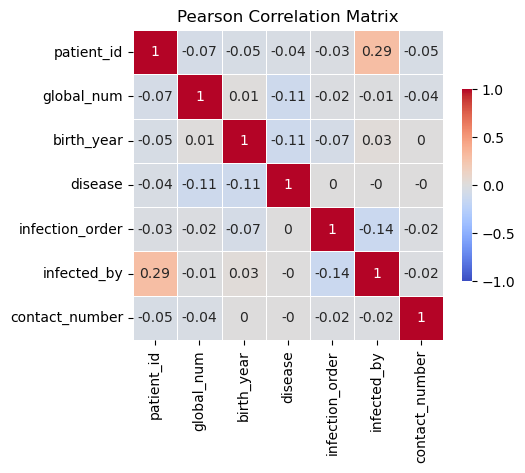

In [37]:
plot_corr_matrix(df, round_vals = 2, mask = False)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [38]:
dfd = df.select_dtypes(include=['float', 'int'])

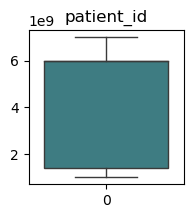

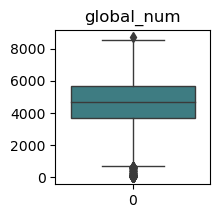

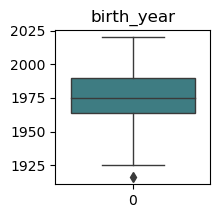

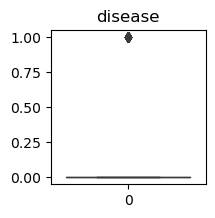

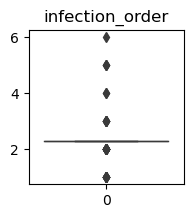

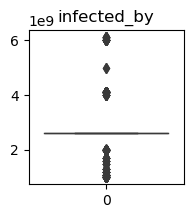

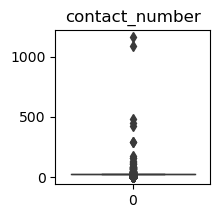

In [39]:
for item in (dfd.columns):
    fig, ax = plt.subplots(figsize=(2,2))
    sns.boxplot(data = dfd[item],
                #orient = 'h',
                width=0.8,
                palette='crest',
                linewidth= 1).set(title = item)
    plt.show()

In [40]:
#Check the age of the oldest person
print(2020 - df.birth_year.min())

104.0


**<font color='teal'> Create dummy features for object type features. </font>**

In [41]:
X = df[df.columns[:-1]]
y = df[[df.columns[-1]]]

print('Independent variables:\n', list(X.columns))
print('\nDependent variable:\n',list(y.columns))

Independent variables:
 ['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country', 'province', 'city', 'disease', 'infection_case', 'infection_order', 'infected_by', 'contact_number']

Dependent variable:
 ['state']


In [42]:
X = pd.get_dummies(X)

### Split the data into test and train subsamples

In [43]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [44]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [45]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [46]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

C:\Users\Farid\AppData\Local\Temp\ipykernel_13740\614593206.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_res = clf.fit(X_train_scaled, y_train)


Random Forest: Accuracy=0.841
Random Forest: f1-score=0.821


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [47]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   0   0]
 [  1 310  17]
 [  0  45  17]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.95 0.05]
 [0.   0.73 0.27]]


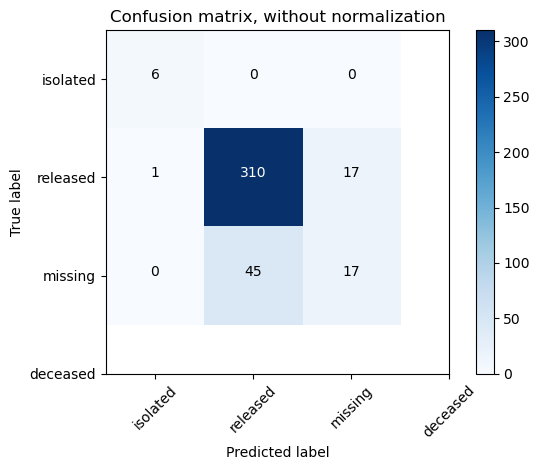

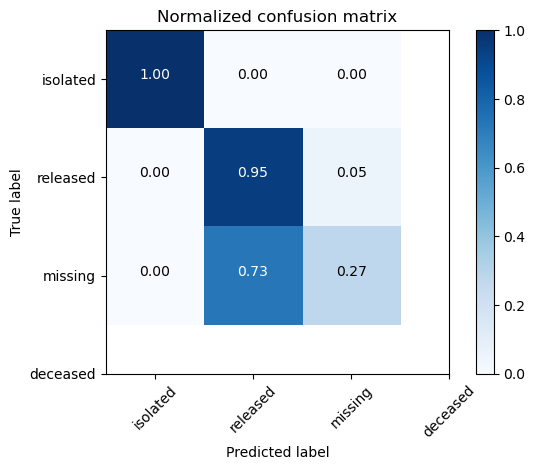

In [48]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


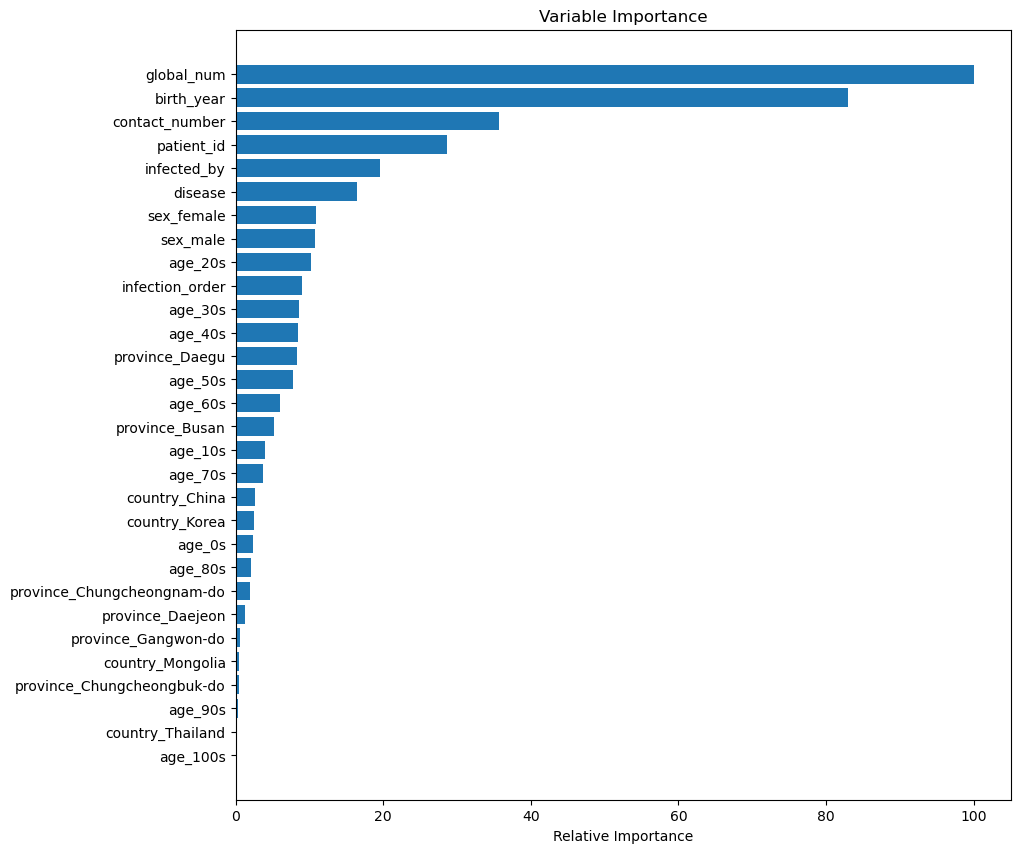

In [49]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.